## Startup

In [1]:
import os
import data_import
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

max_iterations=100000


In [2]:
cache = {}

def exec(N, h, t, s, v=0.01, tm=1):
    dir = "output/{}_{}_{}_{}_{}_{}".format(n,h,t,s,v,tm)
    os.makedirs(dir, exist_ok=True)
    os.chdir(dir)
    key = (N,h,t,s, v, tm)
    c =cache.get(key)
    if not c:    
        
        command = f"java -cp ../../target/gasDiffusion-1.0-SNAPSHOT.jar -DnumParticles={N} -DholeSize={h} -Dseed={s} -Dthreshold={t} -DmaxIterations={max_iterations} -DinitialVelocity={v} -DtimeMultiplier={tm} gasDiffusion.Main"
        proc = os.popen(command)
        time = proc.readlines()[-1]
    else:
        time = c
    data = data_import.Data("2DGasDiffusion.txt")
    cache[key] = time
    os.chdir("../../")
    return (time,data)
    

## 1.2

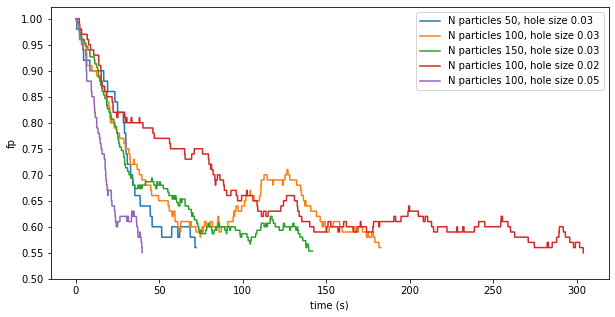

In [9]:
C = [
    (50,0.03)
    ,(100, 0.03)
    ,(150, 0.03)
    ,(100, 0.02)
    ,(100, 0.05)
    ]

plt.figure("fp vs time", figsize=(10,5))
plt.xlabel("time (s)")
plt.ylabel("fp")



for c in C:
    n,h = c
    count = []
    times = []
    time, data = exec(n,h, 0.05, 2022)
    
    for time, a,b, m, t, _data in data:
        count.append(a)
        times.append(time)

    plt.plot(times,count, label=f"N particles {n}, hole size {h}")
    
plt.legend()
plt.yticks(np.arange(0.5,1.05,0.05))
plt.show()
    


## 1.2.2.a

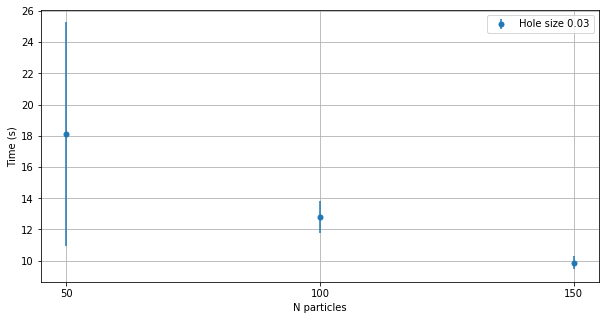

In [4]:
seeds = [2022, 2023, 2024]
N = [50,100,150]
h = 0.03

avg = []
errors = []

plt.figure("Time vs N particles",figsize=(10,5))
plt.xlabel("N particles")
plt.ylabel("Time (s)")

for n in N:
    times = []
    for s in seeds:
        time, data = exec(n,h, 0.05, s)
        times.append(time)
    avg.append(statistics.mean(map(float,times)))
    errors.append(statistics.stdev(map(float,times))/math.sqrt(len(times)))
    
plt.errorbar(N, avg, yerr=errors, fmt="o", label=f"Hole size {h}", markersize=5)
plt.legend()
plt.xticks(N)
plt.grid()
plt.show()



## 1.2.2.b

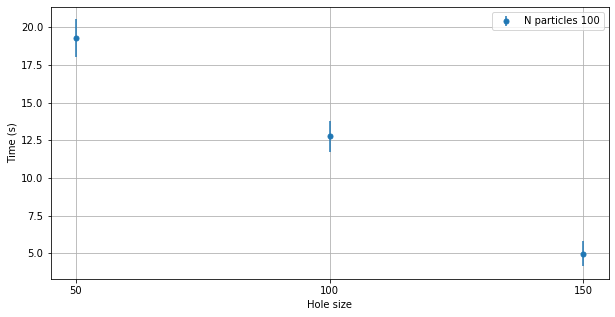

In [5]:
seeds = [2022, 2023, 2024]
H = [0.02,0.03,0.05]
n = 100

avg = []
errors = []

plt.figure("Time vs Hole size",figsize=(10,5))
plt.xlabel("Hole size")
plt.ylabel("Time (s)")

for h in H:
    times = []
    for s in seeds:
        time, data = exec(n,h, 0.05, s)
        times.append(time)
    avg.append(statistics.mean(map(float,times)))
    errors.append(statistics.stdev(map(float,times))/math.sqrt(len(times)))
    
plt.errorbar(N, avg, yerr=errors, fmt="o", label=f"N particles {n}", markersize=5)
plt.legend()
plt.xticks(N)
plt.grid()
plt.show()


## 1.3.1

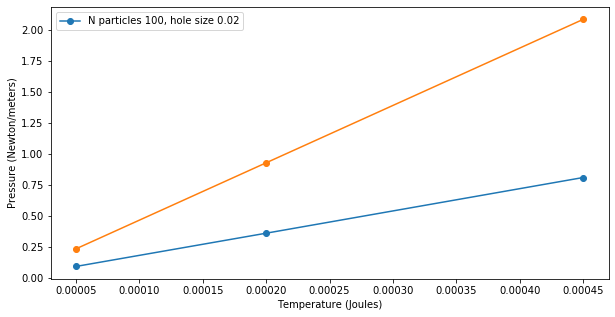

In [16]:
n = 100
h= 0.02
tm = 2
length = 0.24*2 + 0.9*2

V = [0.01, 0.02, 0.03]

plt.figure("P vs T", figsize=(10,5))
plt.xlabel("Temperature")
plt.ylabel("Pressure")

pressures = []
temperatures = []

def press(t):
    v = (0.24*0.09)
    return t*n/v

for v in V:

    time, data = exec(n,h, 0.05, 2022, v, tm)
    time = float(time)
    
    end_time = time
    start_time = time/tm
    
    initial_momentum = 0
    end_momentum = 0
    temp = 0.5*1*v**2
    
    for time, a,b, m, t, _data in data:
        if time >= start_time:
            inital_momentum = m
        else:
            end_momentum = m
    
    pressures.append((end_momentum-initial_momentum)/(length * (end_time - start_time)))
    temperatures.append(temp)
    
plt.figure("P vs T", figsize=(10,5))
plt.xlabel("Temperature (Joules)")
plt.ylabel("Pressure (Newton/meters)")
plt.plot(temperatures, pressures,"o-", label=f"N particles {n}, hole size {h}")
plt.plot(temperatures, [ press(t) for t in temperatures], "o-")
plt.legend()
plt.show(0.01)
    

## 1.4

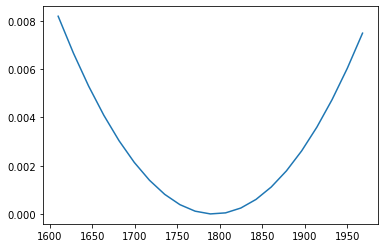

In [21]:
c = (pressures[1] - pressures[0])/(temperatures[1] - temperatures[0])

co = c - c*0.1
cf = c + c*0.1

C = np.arange(co,cf, c*0.01)


def error(c):
    return sum([ (p - t*c)**2 for p,t in zip(pressures, temperatures)])


plt.figure("Error vs C")

plt.plot(C, [error(c) for c in C])

plt.show()
